In [557]:
import chipwhisperer as cw  

scope = cw.scope()
target = cw.target(scope, cw.targets.SimpleSerial) #cw.targets.SimpleSerial can be omitted
scope.default_setup()

In [559]:
import numpy as np

class IncrementalStats:
    def __init__(self):
        self.n = 0
        self.mean = None  # Start with None to handle dynamic sizes
        self.sum_sq = None
        self.variance = None

    def add_trace(self, trace):
        trace_length = len(trace)
        if self.mean is None:
            # Initialize the arrays dynamically based on the first trace length
            self.mean = np.zeros(trace_length)
            self.sum_sq = np.zeros(trace_length)
            self.variance = np.zeros(trace_length)
        elif trace_length != len(self.mean):
            # Adjust the existing arrays to accommodate a trace of new length
            # This case handles if the new trace length is shorter or longer
            if trace_length > len(self.mean):
                # Extend arrays with zeros if new trace is longer
                extension = np.zeros(trace_length - len(self.mean))
                self.mean = np.concatenate((self.mean, extension))
                self.sum_sq = np.concatenate((self.sum_sq, extension))
                self.variance = np.concatenate((self.variance, extension))
            else:
                # If new trace is shorter, use slicing to adjust
                self.mean = self.mean[:trace_length]
                self.sum_sq = self.sum_sq[:trace_length]
                self.variance = self.variance[:trace_length]

        self.n += 1
        delta = trace - self.mean
        self.mean += delta / self.n
        self.sum_sq += trace**2
        if self.n > 1:
            self.variance = (self.sum_sq - self.n * self.mean**2) / (self.n - 1)
        else:
            self.variance = np.zeros_like(self.variance)  # Variance is undefined for n=1

    def get_stats(self):
        return self.mean, self.variance


Recv byte: d
599747
25
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Finished Same CT Test Segment: 0
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Finished Random CT Test Segment: 0
count inc seg 0: 0
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Finished Same CT Test Segment: 1
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h

Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Finished Random CT Test Segment: 13
count inc seg 13: 116
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Finished Same CT Test Segment: 14
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Recv byte: h
Finished Random CT Test Segment: 14
count inc seg 14: 1
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv byte: d
Recv by

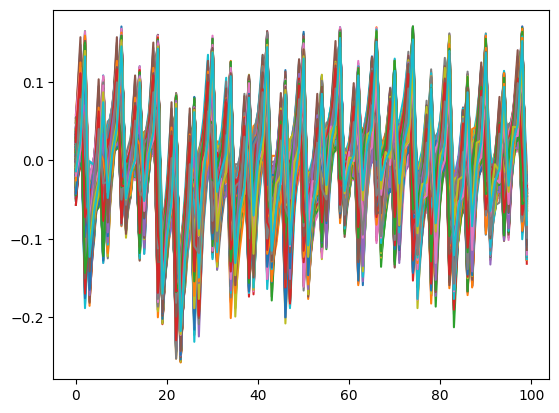

count inc: 2844
count arr: 2844


In [563]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt
import struct
import scipy # 1.13.0
import numpy as np #1.26.4
import json
import os
from scipy.io import loadmat


def mean(data):
    """
        Calculate the mean of the input data along the specified axis.
        
        Parameters:
            data (array-like): Input data for which the mean is calculated.
        
        Returns:
            numpy.ndarray: Mean of the input data.
    """
    return np.mean(data, axis=0)

def variance(data):
    """
        Calculate the variance of the input data along the specified axis.
        
        Parameters:
            data (array-like): Input data for which the variance is calculated.
        
        Returns:
            numpy.ndarray: Variance of the input data.
    """
    return np.var(data, axis=0, ddof=1)


def ttest_ind_2d(sample1, sample2):
    """
        Perform a 2D t-test on two independent samples.
        
        Parameters:
            sample1 (array-like): First sample data.
            sample2 (array-like): Second sample data.
        
        Returns:
            numpy.ndarray: T-statistic values.
    """
    sample1 = np.array(sample1)
    sample2 = np.array(sample2)
    
    # Find the minimum number of columns in both samples
    min_columns = min(sample1.shape[1], sample2.shape[1])
    
    # Resize both samples to the smallest number of columns
    sample1 = sample1[:, :min_columns]
    sample2 = sample2[:, :min_columns]
    
    
    mean1, mean2 = mean(sample1), mean(sample2)
    var1, var2 = variance(sample1), variance(sample2)
    n1, n2 = sample1.shape[0], sample2.shape[0]

    pooled_se = np.sqrt(var1/n1 + var2/n2)
    
    t_stat = (mean1 - mean2) / pooled_se
    return t_stat


def reset_target(scope):
    """
    Reset the target device by toggling the reset pin.
    
    Parameters:
        scope: ChipWhisperer scope object to control the hardware.
    """
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high'
    time.sleep(0.05)

def cap_pass_trace(num, nr, arr, i):
    """
    Capture and pass a trace from the target device.
    
    Parameters:
        num (int): Number to write to the target.
        nr (int): Number of repetitions.
        arr (list): Array to store the captured trace.
        i (int): Index for storing the trace.
    
    Returns:
        numpy.ndarray: Captured trace data.
    
    Raises:
        Exception: If a timeout occurs during acquisition.
    """
    scope.arm()
    target.write(num)
    if not scope.capture():
        trace = scope.get_last_trace()
        arr[i][:] = trace
        if nr == 1:
            plt.plot(trace[0:100])
        return trace
    else:
        print('Timeout happened during acquisition')
        raise Exception("Error occurred in function_deep")
        
        

def send_string(s):
    """
    Send a string to the target device, character by character.
    
    Parameters:
        s (str): String to send to the target.
    """
    for c in s:
        target.write(c.encode())
        
def parser(flag_string, max_no_traces, arr_trace_ct, inc_stats_ct, nr):
    """
    Parse and capture traces from the target device.
    
    Parameters:
        flag_string (str): String containing flags for the target.
        max_no_traces (int): Maximum number of traces to capture.
        arr (list): Array to store the captured traces.
        inc_stats: Incremental statistics object to update with new traces.
        nr (int): Number of repetitions.
    """
    send_string(f"{flag_string}")
    
    recv_byte = 's'; #start
    for i in range (max_no_traces):
        if (recv_byte == 's' or recv_byte == 'd'):  # Start ('s') or Done ('d') with the current trace
            trace = cap_pass_trace(b'g', nr, arr_trace_ct, i)
            inc_stats_ct.add_trace(trace)
            time.sleep(0.1)
            recv_byte = target.read(1)
            while (recv_byte == ""):  #Different implementations have different processing times
                time.sleep(0.1)
                recv_byte = target.read(1)
            if (i % 50 == 0):
                print(f"Recv byte: {recv_byte}")
    target.write(b'e')

    
def run_program(inc_stats_same_ct, inc_stats_random_ct, inc_stats, run_i, max_no_traces, flag_string, t_stats, samples_max, samples_left, total_trace_segments, traces_per_seg, folder_name):
    """
    Run the main program for capturing and analyzing traces from the target device.
    
    Parameters:
        inc_stats_same_ct: Incremental statistics object for same ciphertext traces.
        inc_stats_random_ct: Incremental statistics object for random ciphertext traces.
        inc_stats: Incremental statistics object for the combined statistics.
        run_i (int): Current run index.
        max_no_traces (int): Maximum number of traces to capture.
        flag_string (str): String containing flags for the target.
        t_stats (list): List to store t-statistic values.
        samples_max (int): Maximum number of samples per trace.
        samples_left (int): Number of samples left to capture.
        total_trace_segments (int): Total number of trace segments.
        traces_per_seg (int): Number of traces per segment.
        folder_name (str): Folder name for saving trace data.
    """
    run_offset = run_i * scope.adc.samples
    scope.adc.offset = run_offset
        
    scope.adc.samples = min(scope.adc.samples, samples_left)

    arr_trace_same_ct = [[0 for i in range(scope.adc.samples)] for j in range(max_no_traces)]
    arr_trace_random_ct = [[0 for i in range(scope.adc.samples)] for j in range(max_no_traces)]

    parser(f"{flag_string}", max_no_traces, arr_trace_same_ct, inc_stats_same_ct, run_i)
    print(f"Finished Same CT Test Segment: {run_i}")
    
    parser(f"{flag_string}fw", max_no_traces, arr_trace_random_ct, inc_stats_random_ct, run_i)
    print(f"Finished Random CT Test Segment: {run_i}")
    
    

    # Assume stats1 and stats2 are instances of IncrementalStats for group 1 and group 2
    mean1, var1 = inc_stats_same_ct.get_stats()
    mean2, var2 = inc_stats_random_ct.get_stats()
    n1 = inc_stats_same_ct.n
    n2 = inc_stats_random_ct.n

    # Compute the t-statistic for each point
    pooled_se = np.sqrt(var1 / n1 + var2 / n2)
    inc_values = (mean1 - mean2) / pooled_se
    
    inc_stats[run_offset:run_offset+scope.adc.samples] = inc_values
    
    count = 0
    for stat in inc_stats[run_offset:run_offset+scope.adc.samples]:
        if abs(stat) > 4.5:
#             print(stat)
            count += 1
    print(f"count inc seg {run_i}: {count}")
    
    
    t_stats[run_offset:run_offset+scope.adc.samples] = ttest_ind_2d(arr_trace_same_ct, arr_trace_random_ct)

    # Create the initial directory, the loop creates the sub-directories
    os.makedirs(f"{folder_name}/{max_no_traces}_traces_{samples_max}_samples", exist_ok=True)

    for trace_seg_i in range(total_trace_segments):
        os.makedirs(f'{folder_name}/{max_no_traces}_traces_{samples_max}_samples/{run_i}_run_seg/{trace_seg_i}_trace_seg', exist_ok=True)

        trace_offset = trace_seg_i * traces_per_seg
        
        tmp_arr_same_ct = arr_trace_same_ct[trace_offset:trace_offset+traces_per_seg]
        scipy.io.savemat(f"{folder_name}/{max_no_traces}_traces_{samples_max}_samples/{run_i}_run_seg/{trace_seg_i}_trace_seg/same_ct_test_{samples_max}_{run_i}_{trace_seg_i}.mat", {"same_ct_test": tmp_arr_same_ct})

        tmp_arr_random_ct = arr_trace_random_ct[trace_offset:trace_offset+traces_per_seg]
        scipy.io.savemat(f"{folder_name}/{max_no_traces}_traces_{samples_max}_samples/{run_i}_run_seg/{trace_seg_i}_trace_seg/random_ct_test_{samples_max}_{run_i}_{trace_seg_i}.mat", {"random_ct_test": tmp_arr_random_ct})

        
    scipy.io.savemat(f"{folder_name}/{max_no_traces}_traces_{samples_max}_samples/tstats_{run_i}_{samples_max}.mat", {"tstats": t_stats})
    
        
def mainTest():
    """
    Main test function to set parameters and run the trace capture and analysis.
    """

    #--------FLAGS TO SET--------#
    max_no_traces = 1000
    total_trace_segments = 1
    folder_name = "traces_kyber_masked_sk"
    flags = "l"
    #--------FLAGS TO SET--------#
    
    traces_per_seg = max_no_traces // total_trace_segments
    scope.adc.samples = 24400
    scope.adc.offset = 0
    samples_max = scope.adc.samples
    arr_offset = scope.adc.offset = 0 

    reset_target(scope)
    time.sleep(4)
    target.flush()
    
    flag_string = ""
    
    for f in flags:
        flag_string += f"f{f}"
    # flag_string = "l"
    
    
    inc_stats = IncrementalStats()
    
    #Run it once to determine the 
    arr_0 = [[0 for i in range(samples_max)] for j in range(max_no_traces)]
    parser(f"{flag_string}", 1, arr_0, inc_stats, 0)
    
    nr_runs_full_cap = (scope.adc.trig_count + samples_max - 1) // samples_max  # Round up without math lib
    print("Total trigger count for the capture: " + str(scope.adc.trig_count))
    print("Total number of runs that will be performed: " + str(nr_runs_full_cap))
    
    plt.clf()
    
    t_stats = [0 for i in range(scope.adc.trig_count)]
    inc_stats = [0 for i in range(scope.adc.trig_count)]
     
    run_i = 0
    samples_left = scope.adc.trig_count   # Init samples_left as the total number of triggers
    
    while (run_i < nr_runs_full_cap):
        inc_stats_same_ct = IncrementalStats()
        inc_stats_random_ct = IncrementalStats()
        run_program(inc_stats_same_ct, inc_stats_random_ct, inc_stats, run_i, max_no_traces, flag_string, t_stats, samples_max, samples_left, total_trace_segments, traces_per_seg, folder_name)
        samples_left -= samples_max
        run_i += 1
        
    
    target.write(b'm')
    plt.show()
    
    count = 0
    for stat in inc_stats:
        if abs(stat) > 4.5:
            count += 1
    print(f"count inc: {count}")
    
    
    count = 0
    for stat in t_stats:
        if abs(stat) > 4.5:
            count += 1
    print(f"count arr: {count}")
    
#     print(len(arr_0))

mainTest()